## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [0]:
import os
import keras

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=False, l2_ratio=False):
    input_layer = keras.layers.Input(input_shape)
    
    if l1_ratio>0 and l2_ratio==False:
      for i, n_units in enumerate(num_neurons):
          if i == 0:
              x = keras.layers.Dense(units=n_units, 
                                     activation="relu", 
                                     name="hidden_layer"+str(i+1), 
                                     kernel_regularizer=l1(l1_ratio))(input_layer)
          else:
              x = keras.layers.Dense(units=n_units, 
                                     activation="relu", 
                                     name="hidden_layer"+str(i+1),
                                     kernel_regularizer=l1(l1_ratio))(x)
              
    elif l1_ratio>0 and l2_ratio>0:
      for i, n_units in enumerate(num_neurons):
          if i == 0:
              x = keras.layers.Dense(units=n_units, 
                                     activation="relu", 
                                     name="hidden_layer"+str(i+1), 
                                     kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
          else:
              x = keras.layers.Dense(units=n_units, 
                                     activation="relu", 
                                     name="hidden_layer"+str(i+1),
                                     kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [17]:
results = {}

for r1_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with Regulizer1 = {r1_ratio}")
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=r1_ratio)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "l1-"+str(r1_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer1 = 0.01
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 39us/step - loss: 198.9133 - acc: 0.2347 - val_loss: 41.2718 - val_acc: 0.2846
Epoch 2/50
50000/50000 [==============================] - 2s 32us/step - loss: 19.2046 - acc: 0.1159 - val_loss: 7.3385 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 31us/step - loss: 4.1335 - acc: 0.0995 - val_loss: 2.6538 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.4874 - acc: 0.0974 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.4626 - ac

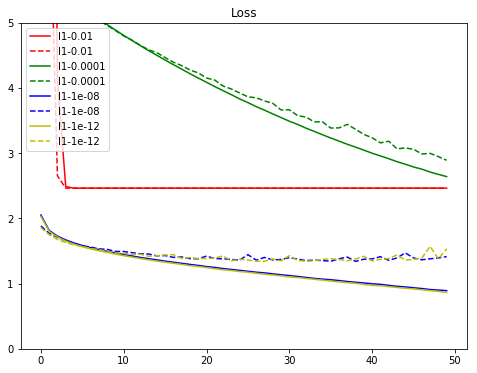

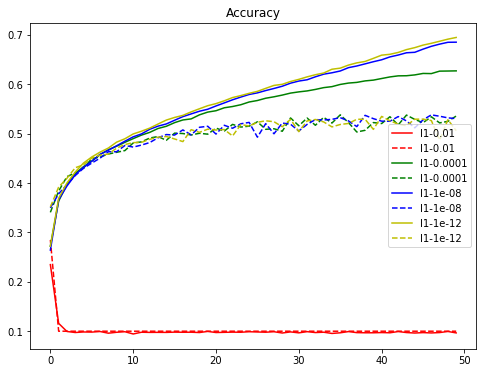

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend();

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend();

In [19]:
results = {}

for r1_ratio, r2_ratio in zip(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with Regulizer1 = {r1_ratio}, Regulizer2 = {r2_ratio}")
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=r1_ratio, l2_ratio=r2_ratio)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "l1-"+str(r1_ratio)+", l2-"+str(r1_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer1 = 0.01, Regulizer2 = 0.01
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 41us/step - loss: 197.7292 - acc: 0.2524 - val_loss: 35.9469 - val_acc: 0.2595
Epoch 2/50
50000/50000 [==============================] - 2s 32us/step - loss: 15.8942 - acc: 0.1118 - val_loss: 5.1128 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 32us/step - loss: 3.2006 - acc: 0.0986 - val_loss: 2.4714 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.4632 - acc: 0.0997 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.4624 - acc: 0.0972 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.4624 - acc: 0.0975 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step 

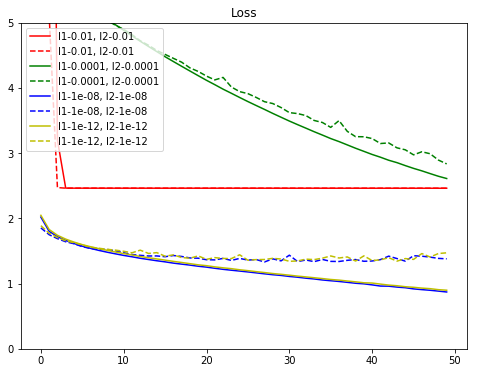

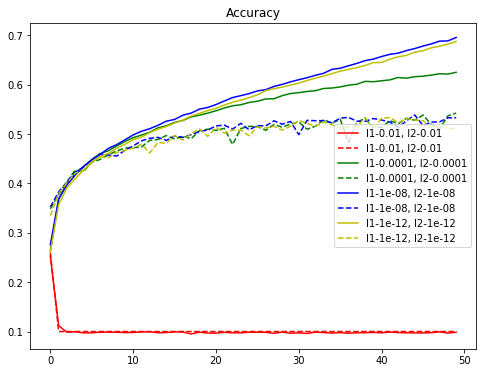

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend();

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend();